# Model Training
###### by Wilson Lee
###### Data Set : China Mobile User Gemographics Source
###### Link : https://www.kaggle.com/chinapage/china-mobile-user-gemographics

This code will develope a predictor for the the interest vector for the provided database. For a given combination of User age, gender, location, hour of day, and day of week, the model will predict a user interest vector using regression.

In [1]:
# import the library
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn :: utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# sklearn :: models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# sklearn :: evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# multi-output
from sklearn.multioutput import MultiOutputRegressor

## Load Data

In [2]:
wDatabaseFolder = "../../Data/Modeling/active_apps_data"

list_of_database = []
for wRoot, wDirs, wFiles in os.walk(wDatabaseFolder):
    for wFilename in wFiles:
        wCurrentFilename = os.path.join(wRoot, wFilename)
        list_of_database.append(pd.read_csv(wCurrentFilename, index_col=None))
            
df_database = pd.concat(list_of_database, axis=0, ignore_index= True)


## View Data

In [3]:
print(df_database.columns.to_list())
df_database.head()

['age', 'day_of_week', 'hour', '3d', '80', '90', 'abroad', 'academic', 'accommodation', 'accounting', 'action', 'activity', 'adventure', 'advice', 'advisory', 'aggregate', 'air', 'amoy', 'animation', 'answer', 'antique', 'app', 'appliance', 'application', 'area', 'around', 'art', 'asia', 'astrology', 'audiobooks', 'automotive', 'aviation', 'avoid', 'baby', 'bank', 'banking', 'based', 'basketball', 'beauty', 'behalf', 'big', 'billards', 'blog', 'bobble', 'book', 'booking', 'box', 'brokerage', 'bus', 'business', 'buy', 'calendar', 'car', 'card', 'care', 'cartoon', 'casual', 'chain', 'channel', 'checkpoint', 'chess', 'child', 'chinese', 'church', 'class', 'classical', 'clock', 'coach', 'collection', 'college', 'comfortable', 'comic', 'commodity', 'community', 'comparing', 'competitive', 'complex', 'condition', 'consumer', 'contact', 'content', 'convenience', 'cool', 'cosplay', 'cost', 'coupon', 'cozy', 'credit', 'crowdfunding', 'cultivation', 'culture', 'custom', 'customization', 'customi

,age,day_of_week,hour,3d,80,90,abroad,academic,accommodation,accounting,...,western,wifi,world,xianxia,zombie,zuma,longitude,latitude,gender_F,gender_M
0,31,0,7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,114.362348,30.871515,1,0
1,31,0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,114.362348,30.871515,1,0
2,31,0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,114.360000,30.870000,1,0
3,31,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,114.360000,30.870000,1,0
4,40,0,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,124.888462,46.618974,0,1


## Model Testing function

In [4]:
def evaluation_chart(test, pred, title):
    plt.scatter(test, pred, alpha=0.3)
    plt.plot(range(0,3, 100), range(0,3, 100), '--r', alpha=0.3, label='Line1')
    plt.title(title)
    plt.xlabel('True Value')
    plt.ylabel('Predict Value')
    plt.xlim([0, 3])
    plt.ylim([0, 3])
    plt.show()

def model_training(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return(y_pred)

def model_evaluation_noplot(title, model, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("Model: {0}, MAE: {1}, RMSE: {2}".format(title,round(mae, 2),round(rmse, 2)))
    importance = []
    if hasattr(model, 'feature_importances_'):
        print('Feature Importance')
        importance = []
        for i in range(len(X_columns)):
            importance.append([X_columns[i], model.feature_importances_[i]])
        print(pd.DataFrame(importance).sort_values(by=1, ascending=False).head(10))
    return(mae, rmse)


def model_evaluation(title, model, y_test, y_pred):
    mae, rmse = model_evaluation_noplot(title, model, y_test, y_pred)
    evaluation_chart(y_test, y_pred, title)
    return(mae, rmse)

def run_experiment_noplot(title, model, X_train, y_train, X_test, y_test):
    y_pred = model_training(model, X_train, y_train, X_test)
    mae, rmse = model_evaluation_noplot(title, model, y_test, y_pred)
    return(mae, rmse)

def run_experiment(title, model, X_train, y_train, X_test, y_test):
    y_pred = model_training(model, X_train, y_train, X_test)
    mae, rmse = model_evaluation(title, model, y_test, y_pred)
    return(mae, rmse)

## Model Definition

In [5]:
models = [
    ('LinearRegression', MultiOutputRegressor(LinearRegression())),
    ('DecisionTreeRegressor', MultiOutputRegressor(DecisionTreeRegressor())),
    ('RandomForestRegressor10', MultiOutputRegressor(RandomForestRegressor(n_estimators=10, random_state=5))),
#    ('RandomForestRegressor25', MultiOutputRegressor(RandomForestRegressor(n_estimators=25, random_state=5))),
#    ('RandomForestRegressor50', MultiOutputRegressor(RandomForestRegressor(n_estimators=50, random_state=5))),
#    ('RandomForestRegressor100', MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=5))),
#    ('RandomForestRegressor200', MultiOutputRegressor(RandomForestRegressor(n_estimators=200, random_state=5))),
#    ('KNeighborsRegressor', MultiOutputRegressor(KNeighborsRegressor())),
]

## Execution Function

In [6]:
def execution(df_data, list_X_column, list_y_column, list_models):
    X = df_data[list_X_column]
    y = df_data[list_y_column]

    threshold = 0.8
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0-threshold, shuffle=True)

    print('X_train', X_train.shape)
    print('y_train', y_train.shape)
    print('X_test', X_test.shape)
    print('y_test', y_test.shape)

    results = []
    for m in list_models:
        precision, recall = run_experiment(m[0], m[1], X_train, y_train, X_test, y_test)
        results.append([m[0], precision, recall])
    return results

def execution_KFold(df_data, list_X_column, list_y_column, list_models):
    X = df_data[list_X_column]
    y = df_data[list_y_column]
    
    k = 5
    
    results = {}
    for m in list_models:
        print('MODEL', m[0])
        results[m[0]] = {'mae':[], 'rmse':[]}
        kf = KFold(n_splits=k,shuffle=True, random_state=5)
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.values[train_index], X.values[test_index]
            y_train, y_test = y.values[train_index], y.values[test_index]
            mae, rmse = run_experiment_noplot(m[0], m[1], X_train, y_train, X_test, y_test)
            results[m[0]]['mae'].append(mae)
            results[m[0]]['rmse'].append(rmse)
    return results


## Define Columns to Use

In [7]:
inputColumns = ['age', 'day_of_week', 'hour', 'longitude', 'latitude', 'gender_F', 'gender_M']
y_columns = [y for y in df_database.columns if (y not in inputColumns)]
X_columns = inputColumns
print(X_columns)
print(y_columns)

['age', 'day_of_week', 'hour', 'longitude', 'latitude', 'gender_F', 'gender_M']
['3d', '80', '90', 'abroad', 'academic', 'accommodation', 'accounting', 'action', 'activity', 'adventure', 'advice', 'advisory', 'aggregate', 'air', 'amoy', 'animation', 'answer', 'antique', 'app', 'appliance', 'application', 'area', 'around', 'art', 'asia', 'astrology', 'audiobooks', 'automotive', 'aviation', 'avoid', 'baby', 'bank', 'banking', 'based', 'basketball', 'beauty', 'behalf', 'big', 'billards', 'blog', 'bobble', 'book', 'booking', 'box', 'brokerage', 'bus', 'business', 'buy', 'calendar', 'car', 'card', 'care', 'cartoon', 'casual', 'chain', 'channel', 'checkpoint', 'chess', 'child', 'chinese', 'church', 'class', 'classical', 'clock', 'coach', 'collection', 'college', 'comfortable', 'comic', 'commodity', 'community', 'comparing', 'competitive', 'complex', 'condition', 'consumer', 'contact', 'content', 'convenience', 'cool', 'cosplay', 'cost', 'coupon', 'cozy', 'credit', 'crowdfunding', 'cultivatio

## Run Model

In [8]:
results = execution_KFold(df_database, X_columns, y_columns, models)

MODEL LinearRegression
Model: LinearRegression, MAE: 0.08, RMSE: 0.2
Model: LinearRegression, MAE: 0.08, RMSE: 0.2
Model: LinearRegression, MAE: 0.08, RMSE: 0.2
Model: LinearRegression, MAE: 0.08, RMSE: 0.2
Model: LinearRegression, MAE: 0.08, RMSE: 0.2
MODEL DecisionTreeRegressor
Model: DecisionTreeRegressor, MAE: 0.05, RMSE: 0.19
Model: DecisionTreeRegressor, MAE: 0.05, RMSE: 0.19
Model: DecisionTreeRegressor, MAE: 0.05, RMSE: 0.19
Model: DecisionTreeRegressor, MAE: 0.05, RMSE: 0.19
Model: DecisionTreeRegressor, MAE: 0.05, RMSE: 0.19
MODEL RandomForestRegressor10
Model: RandomForestRegressor10, MAE: 0.05, RMSE: 0.17
Model: RandomForestRegressor10, MAE: 0.05, RMSE: 0.17
Model: RandomForestRegressor10, MAE: 0.05, RMSE: 0.17
Model: RandomForestRegressor10, MAE: 0.05, RMSE: 0.17
Model: RandomForestRegressor10, MAE: 0.05, RMSE: 0.17


## Model performance

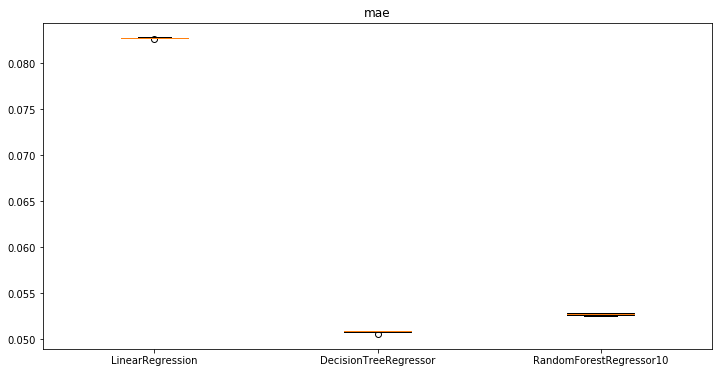

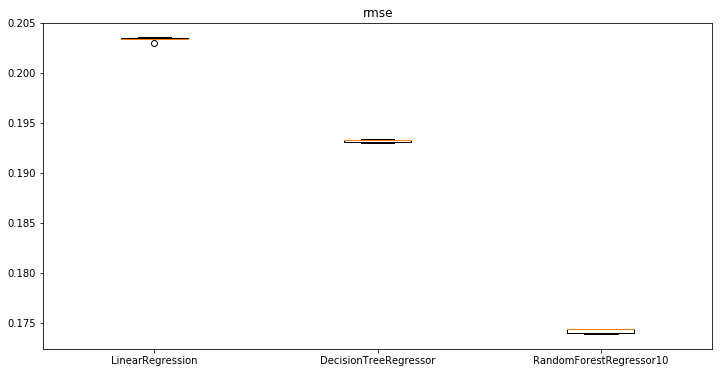

In [9]:
for metric in ['mae', 'rmse']:
    values = []
    labels = []
    for model, result_values in results.items():
        for m, v in result_values.items():
            if m == metric:
                labels.append(model)
                values.append(v)
    plt.figure(figsize=(12,6))
    plt.title(metric)
    plt.boxplot(values)
    plt.xticks(range(1, len(labels)+1), labels, rotation='horizontal')
    plt.show()

## Select Model with Best RMSE

In [10]:
# sort the results and print as a table
sort_column = "rmse"

result_col=['model', 'mae', 'rmse']
df_results = pd.DataFrame(columns=result_col)
for model, result_values in results.items():
    for i in range(0, len(result_values['mae'])):
        entry=pd.DataFrame([[model, result_values[result_col[1]][i], result_values[result_col[2]][i]]],columns=result_col)
        df_results = df_results.append(entry) 

df_results = df_results.groupby('model').mean().reset_index()
df_results = df_results.sort_values(by=sort_column)
df_results

,model,mae,rmse
2,RandomForestRegressor10,0.052749,0.174192
0,DecisionTreeRegressor,0.050841,0.193209
1,LinearRegression,0.082751,0.203345


In [14]:
model_index = df_results[sort_column].idxmin()
print("Using Model {0}".format(models[model_index][0]))
Selected_Model = [models[model_index]]

Using Model RandomForestRegressor10


## Train Best Model with All Data

X_train (301296, 7)
y_train (301296, 417)
X_test (75324, 7)
y_test (75324, 417)
Model: RandomForestRegressor10, MAE: 0.05, RMSE: 0.17


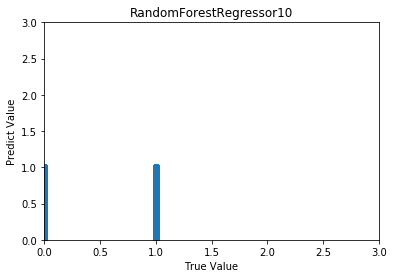

In [15]:
results = execution(df_database, X_columns, y_columns, Selected_Model)

## Save Model

In [17]:
from joblib import dump, load
dump(Selected_Model[0][1], '{0}.joblib'.format(Selected_Model[0][0]))


['RandomForestRegressor10.joblib']

## Save other Models

The RandomForestRegressor10 model is 4GB in size. Trying to saving other models for smaller size model.

In [18]:
OtherModels = [x for x in models if x[0] != Selected_Model[0][0]]

X_train (301296, 7)
y_train (301296, 417)
X_test (75324, 7)
y_test (75324, 417)
Model: LinearRegression, MAE: 0.08, RMSE: 0.2


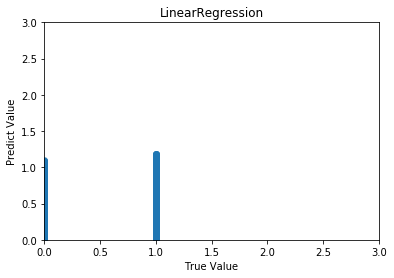

Model: DecisionTreeRegressor, MAE: 0.05, RMSE: 0.19


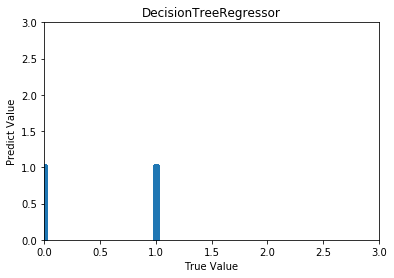

In [19]:
results = execution(df_database, X_columns, y_columns, OtherModels)

In [20]:
for othermodel in OtherModels:
    dump(othermodel[1], '{0}.joblib'.format(othermodel[0]))

Linear Regression Model is 130kb
Decision Tree Regression Model is 566Mb

Linear Regression Model will be used for web application

## Load Selected Model

In [21]:
LinearRegressionModel = load('LinearRegression.joblib')


## Test Loaded Model

In [22]:
# Input['age', 'day_of_week', 'hour', 'longitude', 'latitude', 'gender_F', 'gender_M']
iAge = 25
iDay_of_Week = 0
iHour = 23
iLongitude = 121.38
iLatitude = 31.24
iSex = "Male"
prediction = LinearRegressionModel.predict([[iAge, iDay_of_Week, iHour, iLongitude, iLatitude, (iSex != "Male"), (iSex == "Male")]])
print(prediction)

[[ 3.63705496e-05  3.38836718e-05  1.42658475e-04  2.21257073e-04
  -9.11265995e-05  1.10443664e-03  7.57077460e-02  2.53286295e-03
   1.64043113e-02  9.02039102e-04  9.23937453e-03  2.37192469e-03
   3.82034898e-03  7.73343106e-02  6.15514345e-03  7.91896364e-03
   6.54406673e-03 -4.35814773e-05  3.08627502e-04  1.19473360e-02
   9.69761182e-03  1.00246883e-03  6.56168997e-04  9.16677069e-04
   1.54059389e-03  9.53132954e-04  2.56163031e-03  2.43341514e-02
   1.55569810e-02  1.40004678e-03  3.94075664e-02  1.70280075e-01
   5.36192888e-01  4.92053751e-04  2.58066032e-04  2.92258437e-03
   1.71027201e-03  2.40328551e-03  9.19379580e-04  1.53360173e-02
   3.97805667e-04  6.44970115e-03  7.71264903e-02  6.92032697e-03
   1.40382944e-02  9.23467833e-03  2.74216438e-03  4.76414796e-02
   1.84480699e-02  5.41088776e-02  1.01184232e-01  2.82256617e-03
   2.03501505e-02  2.86479079e-03  5.56787557e-03  6.89311263e-02
   2.11047078e-03  1.04430121e-02  3.80974400e-02  2.85758680e-03
   5.59152

In [38]:
oPrediction = pd.DataFrame(prediction, columns=y_columns)
oPrediction

,3d,80,90,abroad,academic,accommodation,accounting,action,activity,adventure,...,weather,weibo,weight,west,western,wifi,world,xianxia,zombie,zuma
0,0.000036,0.000034,0.000143,0.000221,-0.000091,0.001104,0.075708,0.002533,0.016404,0.000902,...,0.002292,0.198008,0.001495,0.001026,0.000076,0.002725,-5.883142e-07,0.000404,0.000323,0.00004


In [39]:
oPrediction = oPrediction.transpose()
oPrediction.columns = ["Value"]
oPrediction = oPrediction.sort_values("Value", ascending=False).round(3)
oPrediction.head(20)

,Value
industry,0.900
property,0.900
service,0.702
relative,0.652
instant,0.645
message,0.645
custom,0.589
label,0.589
church,0.559
risk,0.558


## Observation

Model Ouput is similar to the results received when adding all the interest vector values together during Exploration analysis. Chart from Exploratino Analysis below.

#### Top 20 Interest of Male Users
![Top 20 Interest of Male Users](../../Docs/Project/Images/ReadMe/Top_interests_male.png)
